# Tissue dielectric calculations
*Author: Dr Vitas Anderson*

Calculate tissue dielectric values using the Gabriel formulas published in:</br>
Gabriel, S. Lau, R.W. & Gabriel, C. (1996) **"The dielectric properties of biological tissues: III.
Parametric models for the dielectric spectrum of tissues"**, *Phys. Med. Biol.* 41 (1996) 2271–2293

Tissue mass proportions were obtained from:</br>
Tahara, Y., Moji, K., Aoyagi, K., Tsunawake, N., Muraki, S., & Mascie-Taylor, C. G. N. (2002). **Age-related pattern of body density and body composition of Japanese men and women 18-59 years of age**. *American Journal of Human Biology*, 14(6). 


## Setup

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from icecream import ic

## Functions

In [9]:
def cce(w, e, tau, alpha):
    """Calculate the Cole-Cole equation for w and the dispersion parameters"""
    return e / (1 + (1j * w * tau)**(1-alpha))

def tissue_dielectric(p, fMHz, factor=1):
    """Calculate the Gabriel tissue dielectric values, er and sigma
       at fMHz frequency
       INPUTS:
         fMHz = frequency in MHz
         p = pandas array containing Gabriel tissue parameters
         factor = factor to multiply er and sigma (e.g. 2/3 for Hurt muscle)
       OUTPUTS:
         er = tissue relative permittivty
         sigma = tissue conductivity in units of S/m
       """
    
    # Permittivity of free space
    e0 = 8.85418782E-12  
    
    # Calculate the angular frequency, w'
    w = 2 * np.pi * (fMHz * 1e6)
    
    # Calculate the complex permitivity'
    ec = p.einf + cce(w,p.e1,p.tau1,p.alpha1) + \
                  cce(w,p.e2,p.tau2,p.alpha2) + \
                  cce(w,p.e3,p.tau3,p.alpha3) + \
                  cce(w,p.e4,p.tau4,p.alpha4) + \
                  p.sigma/(1j*w*e0)
    
    # Multiply ec by factor
    ec = ec * factor
    
    # Calculate permittivity and conductivity
    er = np.real(ec)
    sigma = -w * np.imag(ec) * e0
    
    return er, sigma

## Load tissue data

### Gabriel tissue dielectric parameters

In [10]:
gtdp = pd.read_excel("./data/Gabriel tissue dielectric parameters.xlsx",index_col=0).T.astype(float)
gtdp

TISSUE,einf,sigma,e1,tau1,alpha1,e2,tau2,alpha2,e3,tau3,alpha3,e4,tau4,alpha4
aorta,4.0,0.2500,40.0,8.842000e-12,0.10,50.0,3.183000e-09,0.10,100000.0,0.000159,0.20,10000000.0,0.001592,0.00
bladder,2.5,0.2000,16.0,8.842000e-12,0.10,400.0,1.592000e-07,0.10,100000.0,0.000159,0.20,10000000.0,0.015920,0.00
blood,4.0,0.7000,56.0,8.377000e-12,0.10,5200.0,1.326000e-07,0.10,0.0,0.000159,0.20,0.0,0.015920,0.00
bone cancellous,2.5,0.0700,18.0,1.326000e-11,0.22,300.0,7.958000e-08,0.25,20000.0,0.000159,0.20,20000000.0,0.015920,0.00
bone cortical,2.5,0.0200,10.0,1.326000e-11,0.20,180.0,7.958000e-08,0.20,5000.0,0.000159,0.20,100000.0,0.015920,0.00
bone marrow (infiltrated),2.5,0.1000,9.0,1.447000e-11,0.20,80.0,1.592000e-08,0.10,10000.0,0.001592,0.10,2000000.0,0.015920,0.10
bone marrow (not infiltrated),2.5,0.0005,3.0,7.958000e-12,0.20,25.0,1.592000e-08,0.10,5000.0,0.001592,0.10,2000000.0,0.015920,0.10
breast fat,2.5,0.0100,3.0,1.768000e-11,0.10,15.0,6.366000e-08,0.10,50000.0,0.000455,0.10,20000000.0,0.013260,0.00
cartilage,4.0,0.1500,38.0,1.326000e-11,0.15,2500.0,1.447000e-07,0.15,100000.0,0.000318,0.10,40000000.0,0.015920,0.00
cerebellum,4.0,0.0400,40.0,7.958000e-12,0.10,700.0,1.592000e-08,0.15,200000.0,0.000106,0.22,45000000.0,0.005305,0.00


### Taro model tissue masses

In [11]:
taro = pd.read_excel("./data/Taro tissue masses.xlsx","Gabriel category adjusted data",index_col=0)
taro_mass = taro.mass.sum().round(1)
taro['mass_prop'] = taro.mass / taro_mass
main_tissues = taro.index.to_list()
# ic(taro_mass,main_tissues)
display(taro)


,mass,mass_prop
tissue,,
muscle,26556.00,0.445221
fat (not infiltrated),14445.00,0.242176
bone cortical,8948.80,0.150030
bone cancellous,1789.76,0.030006
bone marrow (not infiltrated),447.44,0.007501
skin - dry,3722.00,0.062401
white matter,699.50,0.011727
grey matter,699.50,0.011727
liver,1185.00,0.019867


### Combine tissue dielectric and mass data 

In [12]:
gtdp_taro = gtdp.merge(taro,left_index=True,right_index=True,how='inner')
gtdp_taro

,einf,sigma,e1,tau1,alpha1,e2,tau2,alpha2,e3,tau3,alpha3,e4,tau4,alpha4,mass,mass_prop
bone cancellous,2.5,0.0700,18.0,1.326000e-11,0.22,300.0,7.958000e-08,0.25,20000.0,0.000159,0.20,20000000.0,0.015920,0.00,1789.76,0.030006
bone cortical,2.5,0.0200,10.0,1.326000e-11,0.20,180.0,7.958000e-08,0.20,5000.0,0.000159,0.20,100000.0,0.015920,0.00,8948.80,0.150030
bone marrow (not infiltrated),2.5,0.0005,3.0,7.958000e-12,0.20,25.0,1.592000e-08,0.10,5000.0,0.001592,0.10,2000000.0,0.015920,0.10,447.44,0.007501
fat (ave. infiltrated),2.5,0.0350,9.0,7.958000e-12,0.20,35.0,1.592000e-08,0.10,33000.0,0.000159,0.05,10000000.0,0.015920,0.01,69.60,0.001167
fat (not infiltrated),2.5,0.0100,3.0,7.958000e-12,0.20,15.0,1.592000e-08,0.10,33000.0,0.000159,0.05,10000000.0,0.007958,0.01,14445.00,0.242176
grey matter,4.0,0.0200,45.0,7.958000e-12,0.10,400.0,1.592000e-08,0.15,200000.0,0.000106,0.22,45000000.0,0.005305,0.00,699.50,0.011727
heart,4.0,0.0500,50.0,7.958000e-12,0.10,1200.0,1.592000e-07,0.05,450000.0,0.000072,0.22,25000000.0,0.004547,0.00,419.00,0.007025
kidney,4.0,0.0500,47.0,7.958000e-12,0.10,3500.0,1.989000e-07,0.22,250000.0,0.000080,0.22,30000000.0,0.004547,0.00,311.00,0.005214
liver,4.0,0.0200,39.0,8.842000e-12,0.10,6000.0,5.305000e-07,0.20,50000.0,0.000023,0.20,30000000.0,0.015920,0.05,1185.00,0.019867
muscle,4.0,0.2000,50.0,7.234000e-12,0.10,7000.0,3.537000e-07,0.10,1200000.0,0.000318,0.10,25000000.0,0.002274,0.00,26556.00,0.445221


### Calculate mass-weighted tissue dielectric values

In [13]:
# Set Dimbylow cross lab validation frequencies
freqs = [30, 40, 50, 60, 65, 70, 80, 90, 100, 120, 150, 180, 200, 300, 
         400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1500, 1800, 
         2000, 2450, 3000]

# Calculate tissue dielectric values by mass proportions
tlist = []
for fMHz in freqs:
    for t in gtdp_taro.itertuples():
        prop = t.mass_prop
        er, sigma = tissue_dielectric(t, fMHz)
        erp = er * prop
        sigmap = sigma * prop
        tlist.append([t.Index,fMHz,prop,er,erp,sigma,sigmap])

cols=('tissue','fMHz','prop','er','erp','sigma','sigmap')
diel = pd.DataFrame(tlist,columns=cols)
diel.to_clipboard()
diel.head(20)

,tissue,fMHz,prop,er,erp,sigma,sigmap
0,bone cancellous,30,0.030006,40.158897,1.205007,0.144001,0.004321
1,bone cortical,30,0.150030,20.938870,3.141455,0.052467,0.007872
2,bone marrow (not infiltrated),30,0.007501,9.883122,0.074138,0.017721,0.000133
3,fat (ave. infiltrated),30,0.001167,17.171943,0.020037,0.061700,0.000072
4,fat (not infiltrated),30,0.242176,8.109602,1.963948,0.033244,0.008051
5,grey matter,30,0.011727,152.532199,1.788801,0.424687,0.004980
6,heart,30,0.007025,150.436180,1.056767,0.597879,0.004200
7,kidney,30,0.005214,176.867321,0.922191,0.637387,0.003323
8,liver,30,0.019867,113.454545,2.253996,0.389235,0.007733
9,muscle,30,0.445221,91.810188,40.875812,0.658026,0.292967


In [88]:
# Calculate total mass-weighted tissue dielectric values for Taro tissues
mask = diel.tissue.isin(taro.index)
dielmw = diel[mask].pivot_table(values=['erp','sigmap'],index=['fMHz'],aggfunc=sum).round(3)
dielmw.to_clipboard()

# Calculate dielectric values for 2/3 muscle
tt = []
for fMHz in freqs:
    er, sigma = tissue_dielectric(p=gtdp.loc['muscle'], fMHz=fMHz, factor=2/3)
    tt.append([fMHz,er,sigma])

muscle23 = pd.DataFrame(tt, columns=['fMHz','er 2/3 muscle','sigma 2/3 muscle']).round(3)
muscle23.set_index('fMHz',inplace=True)

dielmw.merge(muscle23,left_index=True,right_index=True)

,erp,sigmap,er 2/3 muscle,sigma 2/3 muscle
fMHz,,,,
30,64.843,0.362,61.207,0.439
40,57.143,0.372,55.050,0.446
50,52.517,0.379,51.375,0.452
60,49.426,0.386,48.923,0.457
65,48.235,0.388,47.979,0.459
70,47.212,0.391,47.168,0.461
80,45.545,0.396,45.846,0.465
90,44.243,0.400,44.812,0.469
100,43.197,0.404,43.981,0.472


### Quadratic curve fits for $\sigma(\epsilon_r)$

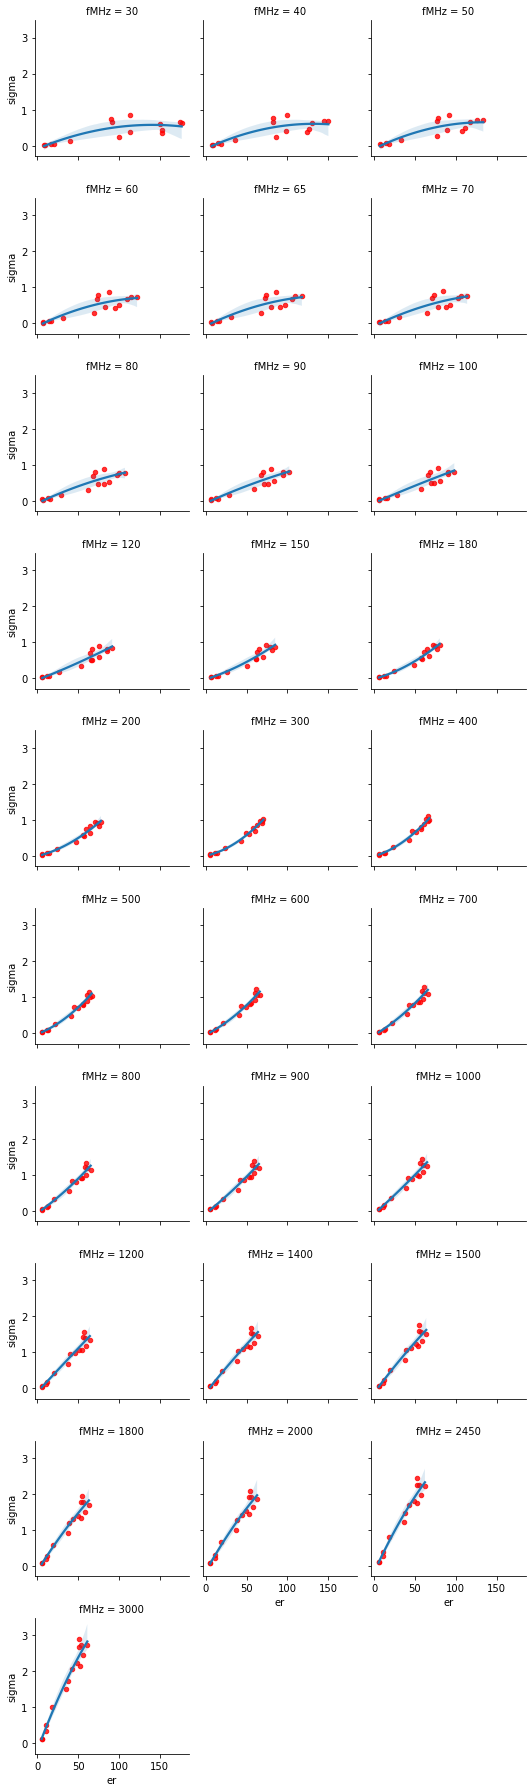

In [89]:
# plot curves for quadratic fit
mask = diel.tissue.isin(taro.index)
sn.lmplot(x="er",y="sigma",col='fMHz',col_wrap=3, #hue='tissue',
          order=2, ci=95, height=2.5,scatter_kws={"s": 20,'color':'r'}, 
          data=diel[mask])
plt.savefig('../plots/sigma v er per freq.png',dpi=200)

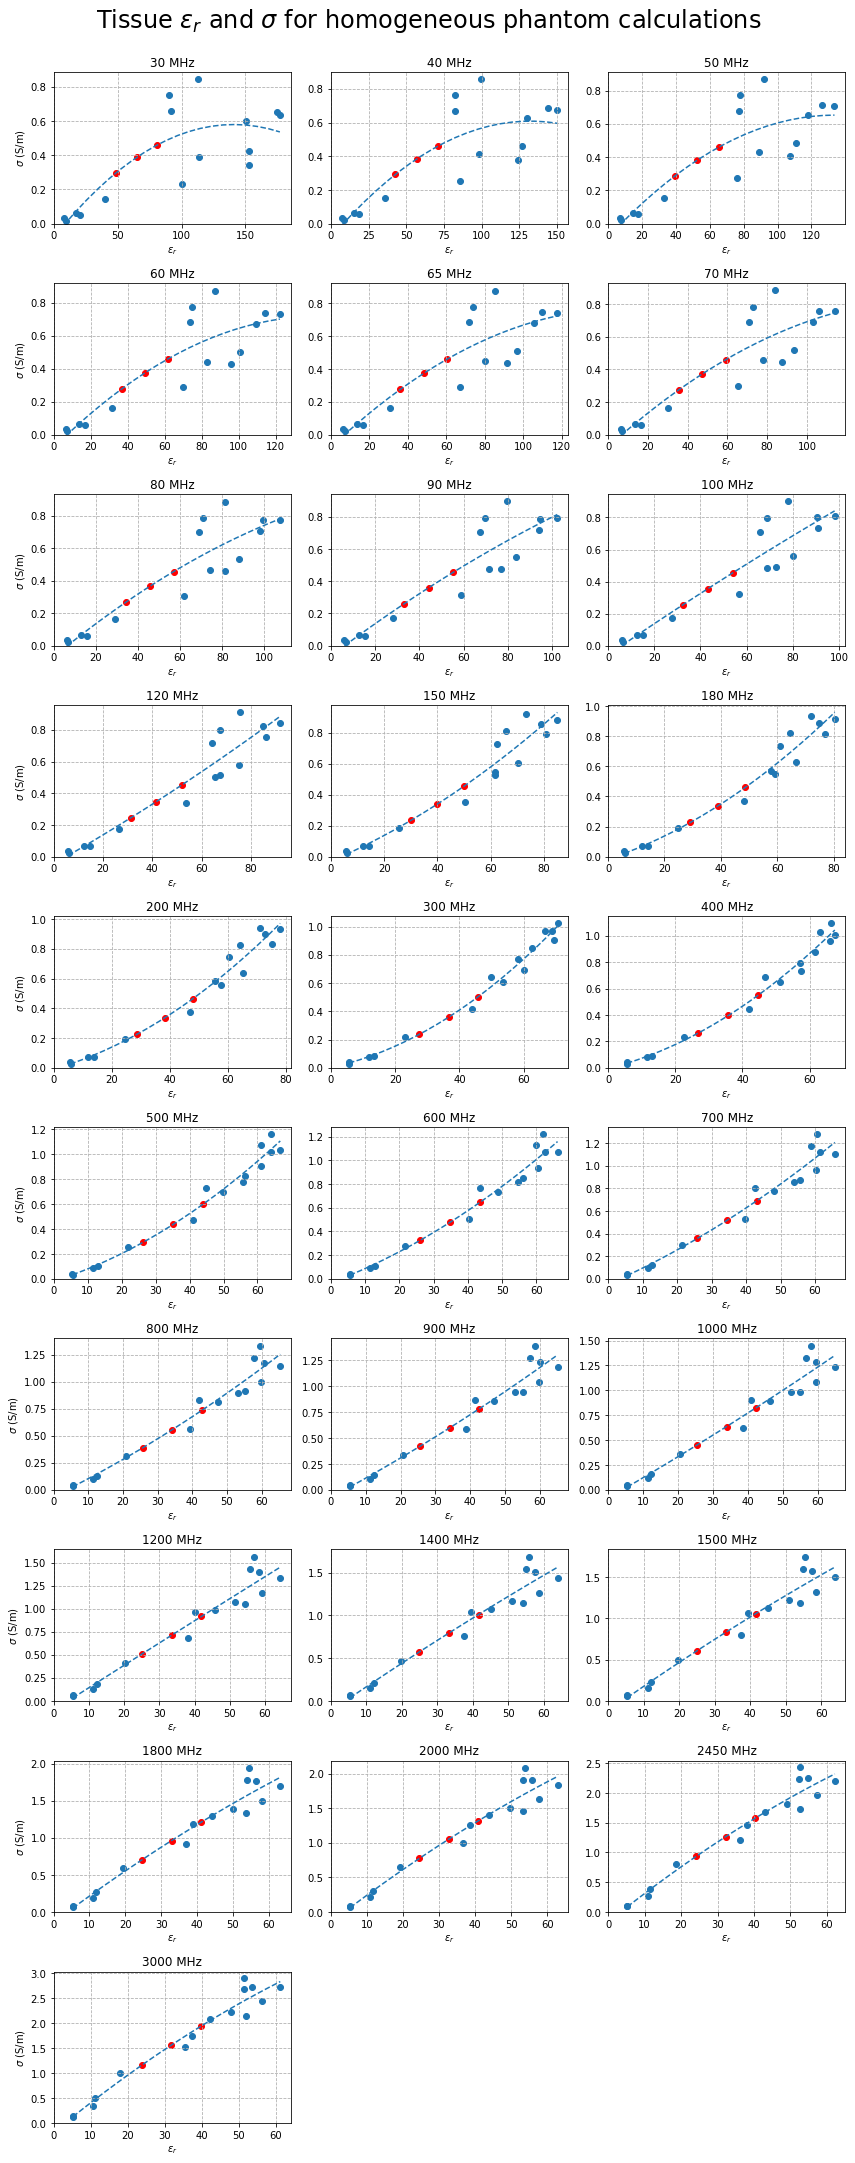

In [126]:
def make_quadfit(x,y):
    c = np.polyfit(x,y,2)
    quadfit = lambda x: c[0]*x**2 + c[1]*x + c[2]
    return quadfit, c

fig, ax = plt.subplots(10,3,figsize=(12,30))
ax = ax.flatten()

dalpha = 0.25  # delta alpha
dielalpha = pd.DataFrame(columns=('fMHz','alpha','er','sigma'))
dfcoeffs = pd.DataFrame(columns=('fMHz','c0','c1','c2'))
mask = diel.tissue.isin(taro.index)
for i, (f, g) in enumerate(diel[mask].groupby('fMHz')):
    # get Gabriel data for tissues at f MHz
    erf, sigf = g.er.values, g.sigma.values
    
    # create function to fit Gabriel sigma to quadratic polynomial in er 
    quadfit, c = make_quadfit(erf, sigf)
    row = {'fMHz':f,'c0':c[0],'c1':c[1],'c2':c[2]}
    dfcoeffs = dfcoeffs.append(row,ignore_index=True)
    
    # calculate points for quadratic fit function
    eri = np.linspace(erf.min(),erf.max(),20)
    sigi = quadfit(eri)
    
    # get mass weighted values for er and sigma
    erp, sigmap = dielmw.loc[f,['erp','sigmap']].values
    
    # calculate alpha points
    alpha = [1-dalpha, 1, 1+dalpha]
    era = np.array([erp*a for a in alpha])
    siga = quadfit(era)
    for a, er, sig in zip(alpha,era,siga):
        row = {'fMHz':f,'alpha':a,'er':er,'sigma':sig}
        dielalpha = dielalpha.append(row,ignore_index=True)    
    
    #plot data
    ax[i].scatter(erf,sigf)
    ax[i].scatter(era,siga,color='r')
    ax[i].plot(eri,sigi,'--')
    ax[i].set_title(f'{f} MHz')
    ax[i].set_xlim(left=0)
    ax[i].set_ylim(bottom=0)
    ax[i].grid(ls='--')
    ax[i].set_xlabel('$\epsilon_r$')
    if i % 3 == 0:
        ax[i].set_ylabel('$\sigma$ (S/m)')

ax[28].remove()
ax[29].remove()
title = 'Tissue $\epsilon_r$ and $\sigma$ for homogeneous phantom calculations'
fig.suptitle(title,y=1,fontsize=24)
fig.tight_layout()
fig.savefig('../plots/er v sigma homog.png')
dielalpha.to_clipboard()
# dfcoeffs.style.format({'fMHz':'{0:,g}','c0':'{0:,.3e}','c1':'{0:,.3e}','c2':'{0:,.3e}'})

array([-3.33538482e-05,  9.39503737e-03, -8.23141029e-02])

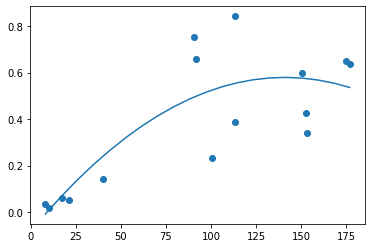

In [49]:
def make_quadfit(x,y):
    coeffs = np.polyfit(erf,sigf,2)
    quadfit = lambda x: fn[0]*x**2 + fn[1]*x + fn[2]
    return quadfit, coeffs
    
mask = diel.fMHz == 30
erf = diel.loc[mask,'er']
sigf = diel.loc[mask,'sigma']
erfi = np.linspace(erf.min(),erf.max(),20)
quadfit, coeffs = make_quadfit(erf,sigf)
sigi = quadfit(erfi)

fig, ax = plt.subplots()
ax.scatter(erf,sigf)
ax.plot(erfi,sigi)
coeffs


## Create plots of tissue dielectric parameters

### Create dataframe of $\epsilon_r$ and $\sigma$ for all tissues and selected frequencies

In [9]:
freqs2 = [100,200,400,1000,2000,5000]

tt = []
for fMHz in freqs2:
    for row in gtdp.itertuples():
        er, sigma = tissue_dielectric(row, fMHz=fMHz)
        tt.append([row.Index,fMHz,er,sigma])

df = pd.DataFrame(tt, columns=['tissue','fMHz','er','sigma']).round(3)



# df = pd.DataFrame(columns=['er','sigma','fMHz'])
# for fMHz in freqs:
#     td = gtdp.apply(tissue_dielectric, axis=1, fMHz=fMHz)
#     td.columns = ['er','sigma']
#     td['fMHz'] = fMHz
#     df = pd.concat([df,td])    

# df = df.rename_axis('tissue').reset_index()
df

,tissue,fMHz,er,sigma
0,aorta,100,59.780,0.462
1,bladder,100,22.652,0.294
2,blood,100,76.822,1.233
3,bone cancellous,100,27.629,0.172
4,bone cortical,100,15.282,0.064
...,...,...,...,...
259,tongue,5000,48.996,4.268
260,trachea,5000,36.864,3.340
261,uterus,5000,53.681,4.979
262,vitreous humour,5000,65.810,5.411


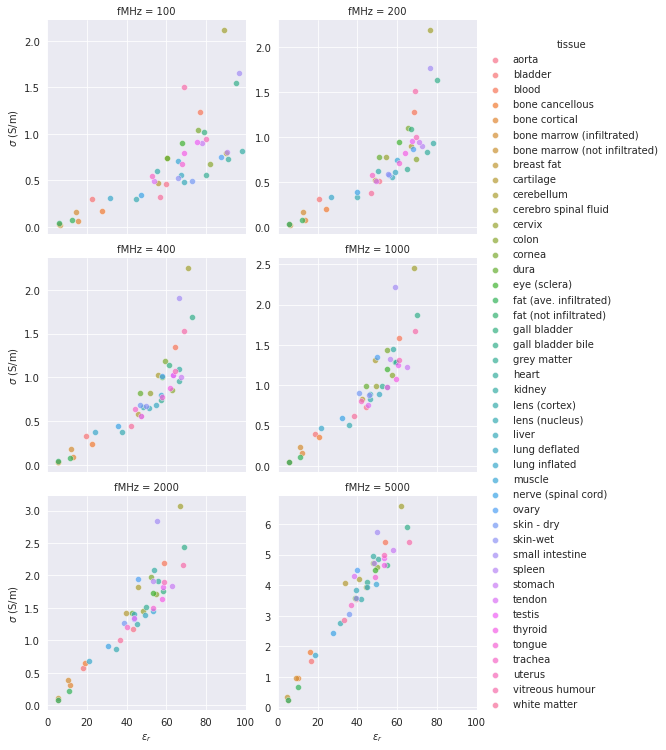

In [10]:
with sn.axes_style("darkgrid"):
    g = sn.FacetGrid(df, col="fMHz", col_wrap=2, height=3.5,
                     hue="tissue",xlim=(0,100),sharey=False)
    g.map(sn.scatterplot, "er", "sigma", alpha=.7)
    g.add_legend()
    g.set_axis_labels(r'$\epsilon_r$',r'$\sigma$ (S/m)')
    g.tight_layout()
    g.savefig('../plots/sigma v er.png',dpi=200)

## Scratch

### Create log scale of investigation frequencies

In [47]:
freqs = np.logspace(2,np.log10(6000),num=21).round(1)
print(*freqs, sep=', ')

100.0, 122.7, 150.6, 184.8, 226.8, 278.3, 341.5, 419.1, 514.4, 631.2, 774.6, 950.6, 1166.5, 1431.5, 1756.7, 2155.8, 2645.6, 3246.6, 3984.2, 4889.3, 6000.0


### test out the cce function

In [49]:
fMHz = 100
tissue = 'aorta'

print(tissue)
w = 2 * np.pi * fMHz * 1e6
for i in [1,2,3,4]:
    e, tau, alpha = gtdp.loc[tissue,"e"+str(i):"alpha"+str(i)]
    print(f'{i}: {w=}, {e=}, {tau=}, {alpha=}')
    disp = cce(w,e,tau,alpha) 
    print(f'{disp=}\n')

aorta
1: w=628318530.7179587, e=40.0, tau=8.842e-12, alpha=0.1
disp=(39.93826589119501-0.3678176108102568j)

2: w=628318530.7179587, e=50.0, tau=3.183e-09, alpha=0.1
disp=(12.751218109509889-18.190916334023942j)

3: w=628318530.7179587, e=100000.0, tau=0.0001592, alpha=0.2
disp=(3.090278827925935-9.507824174111935j)

4: w=628318530.7179587, e=10000000.0, tau=0.001592, alpha=0.0
disp=(9.994340385406586e-06-9.997169792194487j)

